This notebook reproduces and extends generative agent simulations to evaluate decision-making mechanisms across different levels of reward uncertainty (the 80-20 and 70-30 bandit conditions). 
Using robust 5-fold Cross-Validation and Maximum Likelihood Estimation, it estimates parameters from actual mouse data and runs simulations on true state sequences to validate both macro-behaviour (efficiency) and micro-mechanisms (cognitive lag). It also investigates parameter shifts between the two environments to highlight the biological limitations of static models.

Models:
1. RFLR (Static) - Generative agent simulated using mouse-fit parameters ($\alpha$, $\beta$, $\tau$) obtained via 5-fold CV for each condition.
2. Ideal HMM (Thompson Sampling) - Theoretically optimal Bayesian observer utilising true task parameters.
3. Sticky HMM - Bayesian inference model that incorporates the stickiness ($\alpha$) parameter derived from the RFLR fits.

Metrics & Visualisations:
1. Reward vs. Cognitive Cost (Efficiency Frontier): Evaluates the overall performance by plotting the reward per session against the behavioural strategy (switches per session). 
2. Switch Dynamics: Measures the event-triggered probability of switching ports relative to a block reversal to visualise cognitive lag. 
3. Parameter Shift: A comparative analysis of fitted $\alpha$, $\beta$, and $\tau$ values across the 70-30 and 80-20 environments to prove environmental adaptation.

Conclusions:
The Ideal HMM will physically over-switch in a noisy environment (70-30) due to its over-sensitivity to unrewarded trials, whereas models incorporating static stickiness (RFLR and Sticky HMM) will successfully mimic the mouse's "cognitive lag" to maintain cognitive economy. Furthermore, the cross-environment validation exposes that real mice do not use a hardcoded strategy; rather, they actively modulate their stickiness ($\alpha$) to react faster in the more deterministic 80-20 environment. This conclusion proves the brittleness of static parameters and sets up the foundation for testing dynamic, surprise-dependent $\alpha$ (meta-learning) models.

In [1]:
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem

In [2]:
repo_path = os.path.abspath(os.path.join(os.getcwd(), "..", "reproduction", "2ABT_behaviour_models_updated"))
if repo_path not in sys.path:
    sys.path.append(repo_path)
    
import model_fitting as fit
import model_simulations as sim

In [3]:
fig_dir = os.path.join("phase2_generative", "figures")
os.makedirs(fig_dir, exist_ok=True)

In [4]:
data_path = os.path.join(repo_path, "mouse_data.csv")
df = pd.read_csv(data_path)

In [5]:
def extract_sessions(df, condition):
    """
    Extracts sessions for a specific condition.
    Returns:
        sessions: List of (choices, rewards) tuples for model fitting
        targets: List of true target states (0/1) for simulations
    """
    subset = df[df["Condition"] == condition]
    sessions_list = []
    targets_list = []
    
    for sess_id, group in subset.groupby("Session"):
        # Sort by trial
        group = group.sort_values("Trial")
        
        c = group["Decision"].astype(int).values
        r = group["Reward"].astype(int).values
        state = group["Target"].astype(int).values
        
        sessions_list.append((c, r))
        targets_list.append(state)
        
    return sessions_list, targets_list

In [6]:
sess_80, targ_80 = extract_sessions(df, "80-20")
sess_70, targ_70 = extract_sessions(df, "70-30")

In [7]:
print(f"80-20 Data: {len(sess_80)} sessions")
print(f"70-30 Data: {len(sess_70)} sessions")

80-20 Data: 159 sessions
70-30 Data: 200 sessions


In [8]:
from sklearn.model_selection import KFold
def run_rflr_cv(sessions, condition, n_splits=5):
    """
    Performs 5-fold Cross Validation to fit RFLR parameters and calculate held-out NLL.
    Returns: DataFrame of results for each fold.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=11)
    results = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(sessions)):
        # Split train and test dataset
        train_data = [sessions[i] for i in train_idx]
        test_data = [sessions[i] for i in test_idx]
        
        # Fit on Train (minimising Negative Log Likelihood)
        params, nll = fit.fit_with_sgd(
            fit.log_probability_rflr, 
            train_data, 
            init_parameters=(0.0, 1.0, 2.0), # initial parameters: alpha, beta, tau
            num_steps=10000,
            step_size=0.01 # learning rate
        )
        params = [np.array(p).item() for p in params] 
        alpha, beta, tau = params
        
        # Evaluate on Test (held-out average LL)
        test_avg_ll = fit.log_probability_rflr(params, test_data)
        
        results.append({
            "Condition": condition,
            "Fold": fold,
            "Alpha": alpha,
            "Beta": beta,
            "Tau": tau,
            "Test_LL": test_avg_ll
        })
        
    return pd.DataFrame(results)

In [9]:
cv_80 = run_rflr_cv(sess_80, "80-20")
cv_70 = run_rflr_cv(sess_70, "70-30")

iteration  0 neg ll:  0.25784305
iteration  2500 neg ll:  0.18557419
iteration  5000 neg ll:  0.18404722
iteration  7500 neg ll:  0.18332525
iteration  0 neg ll:  0.25551924
iteration  2500 neg ll:  0.18020353
iteration  5000 neg ll:  0.17865014
iteration  7500 neg ll:  0.17793342
iteration  0 neg ll:  0.26018998
iteration  2500 neg ll:  0.18822289
iteration  5000 neg ll:  0.18671289
iteration  7500 neg ll:  0.18605642
iteration  0 neg ll:  0.25645432
iteration  2500 neg ll:  0.18340684
iteration  5000 neg ll:  0.18186308
iteration  7500 neg ll:  0.18117109
iteration  0 neg ll:  0.25740036
iteration  2500 neg ll:  0.18507223
iteration  5000 neg ll:  0.18350361
iteration  7500 neg ll:  0.18275233
iteration  0 neg ll:  0.3007071
iteration  2500 neg ll:  0.19610183
iteration  5000 neg ll:  0.19456412
iteration  7500 neg ll:  0.19403772
iteration  0 neg ll:  0.30293557
iteration  2500 neg ll:  0.20193091
iteration  5000 neg ll:  0.2004877
iteration  7500 neg ll:  0.19996127
iteration  0 ne

In [10]:
cv_results = pd.concat([cv_80, cv_70])
cv_results.to_csv(os.path.join("phase2_generative", "cv_results_fitted.csv"), index=False)
print("\nModel Fits (Mean +/- SEM):")
print(cv_results.groupby("Condition")[["Alpha", "Beta", "Tau", "Test_LL"]].agg(['mean', 'sem']))


Model Fits (Mean +/- SEM):
              Alpha                Beta                 Tau            \
               mean       sem      mean       sem      mean       sem   
Condition                                                               
70-30      1.072119  0.009617  1.660942  0.007547  1.845371  0.009157   
80-20      0.812948  0.007309  1.722471  0.010037  1.725962  0.005184   

            Test_LL            
               mean       sem  
Condition                      
70-30     -0.197331  0.004074  
80-20     -0.182028  0.005282  


In [11]:
def simulate_agents(targets, p_reward, p_switch, alpha, beta, tau):
    """
    Runs 3 agents on the provided target sequences:
    1. RFLR Agent (using fitted params)
    2. Sticky HMM (using fitted RFLR params)
    3. Ideal HMM (Standard Thompson Sampling)
    """
    # 1. RFLR Agent (Generative)
    rflr_sessions = []
    gamma = np.exp(-1.0/tau)
    
    for states in targets:
        T = len(states)
        c, r = np.zeros(T, dtype=int), np.zeros(T, dtype=int)
        phi = 0
        c[0] = np.random.randint(2) # random start
        
        for t in range(1, T):
            # Recursive Belief Update
            prev_c = 2*c[t-1] - 1
            prev_r = r[t-1]
            phi = phi * gamma + beta * prev_r * prev_c
            psi = phi + alpha * prev_c
            
            # Stochastic Decision
            p_right = 1 / (1 + np.exp(-psi))
            c[t] = int(np.random.rand() < p_right)
            
            # Outcome (Probabilistic Reward)
            if c[t] == states[t]:
                r[t] = int(np.random.rand() < p_reward)
            else:
                r[t] = int(np.random.rand() < (1-p_reward))
        rflr_sessions.append((c, r))

    # 2. Sticky HMM 
    # Feed RFLR parameters directly. sim.BayesianMouse subtracts internal HMM bias.
    stickyHMM_params = {'p_switch': p_switch, 'p_reward': p_reward, 
                     'alpha': alpha, 'beta': beta, 'tau': tau}
    mouse_stickyHMM = sim.BayesianMouse(stickyHMM_params)
    stickyHMM_res = sim.simulate_experiment(stickyHMM_params, mouse_stickyHMM, targets, policy='stochastic', sticky=True)
    stickyHMM_sessions = [(np.array(x[0]), np.array(x[1])) for x in stickyHMM_res]

    # 3. Ideal HMM (Standard Thompson Sampling)
    idealHMM_params = {'p_switch': p_switch, 'p_reward': p_reward}
    mouse_idealHMM = sim.BayesianMouse(idealHMM_params)
    idealHMM_res = sim.simulate_experiment(idealHMM_params, mouse_idealHMM, targets, policy='thompson', sticky=False)
    idealHMM_sessions = [(np.array(x[0]), np.array(x[1])) for x in idealHMM_res]

    return rflr_sessions, stickyHMM_sessions, idealHMM_sessions

In [12]:
cv_results = pd.read_csv(os.path.join("phase2_generative", "cv_results_fitted.csv"))

alpha_80 = cv_results[cv_results["Condition"] == "80-20"]["Alpha"].mean()
beta_80 = cv_results[cv_results["Condition"] == "80-20"]["Beta"].mean()
tau_80 = cv_results[cv_results["Condition"] == "80-20"]["Tau"].mean()

alpha_70 = cv_results[cv_results["Condition"] == "70-30"]["Alpha"].mean()
beta_70 = cv_results[cv_results["Condition"] == "70-30"]["Beta"].mean()
tau_70 = cv_results[cv_results["Condition"] == "70-30"]["Tau"].mean()

In [13]:
est_p_switch_80 = 1.0 / np.mean([len(t)/np.sum(np.abs(np.diff(t))) for t in targ_80])
est_p_switch_70 = 1.0 / np.mean([len(t)/np.sum(np.abs(np.diff(t))) for t in targ_70])

In [14]:
sim_rflr_80, sim_sticky_80, sim_ideal_80 = simulate_agents(targ_80, 0.8, est_p_switch_80, alpha_80, beta_80, tau_80)
sim_rflr_70, sim_sticky_70, sim_ideal_70 = simulate_agents(targ_70, 0.7, est_p_switch_70, alpha_70, beta_70, tau_70)

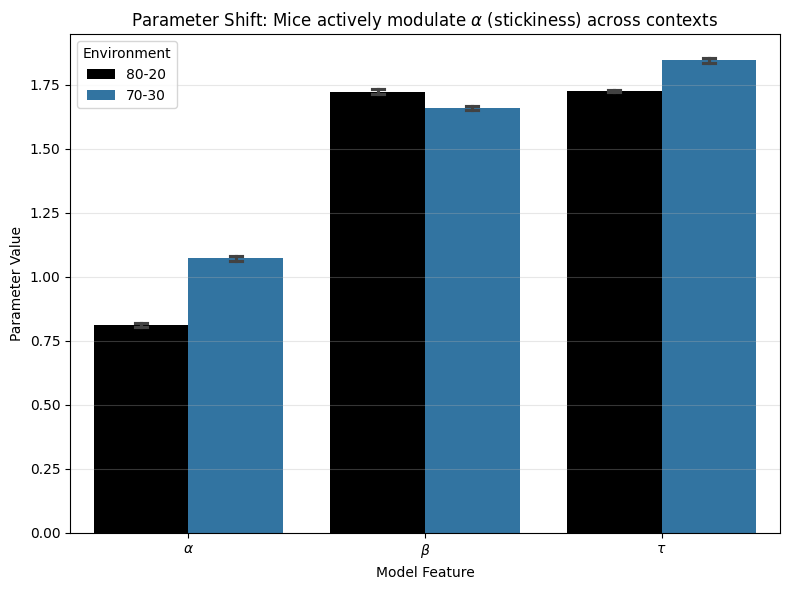

In [15]:
df_params = cv_results.melt(id_vars=["Condition", "Fold", "Test_LL"], 
                            value_vars=["Alpha", "Beta", "Tau"], 
                            var_name="Parameter", value_name="Value")

df_params["Parameter"] = df_params["Parameter"].replace({
    "Alpha": r"$\alpha$", 
    "Beta": r"$\beta$", 
    "Tau": r"$\tau$"
})

plt.figure(figsize=(8, 6))

sns.barplot(data=df_params, x="Parameter", y="Value", hue="Condition", 
            palette=["black", "tab:blue"], capsize=.1, errorbar="se")

plt.title(r"Parameter Shift: Mice actively modulate $\alpha$ (stickiness) across contexts")
plt.ylabel("Parameter Value")
plt.xlabel("Model Feature")
plt.legend(title="Environment")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "Parameter Shift.png"), dpi=300, bbox_inches='tight')
plt.show()

In [16]:
def get_switch_prob_around_transition(sessions, targets, window_pre=5, window_post=10):
    aligned_switches = {i: [] for i in range(-window_pre, window_post + 1)}
    
    for (choices, _), states in zip(sessions, targets):
        # Find transition indices
        transitions = np.where(np.abs(np.diff(states)) > 0)[0] + 1
        
        # Calculate switch array (1 if switched from prev, 0 if stay)
        did_switch = np.abs(np.diff(choices))
        did_switch = np.insert(did_switch, 0, 0)
        
        for t_idx in transitions:
            for rel_t in range(-window_pre, window_post + 1):
                abs_t = t_idx + rel_t
                if 0 <= abs_t < len(choices):
                    aligned_switches[rel_t].append(did_switch[abs_t])
                    
    # Safely compute Average and Standard Error
    x = sorted(aligned_switches.keys())
    y, err = [], []
    for k in x:
        vals = aligned_switches[k]
        if len(vals) > 1:
            y.append(np.mean(vals))
            err.append(sem(vals))
        elif len(vals) == 1:
            y.append(np.mean(vals))
            err.append(0.0)
        else:
            y.append(np.nan)
            err.append(np.nan)
            
    return x, y, err

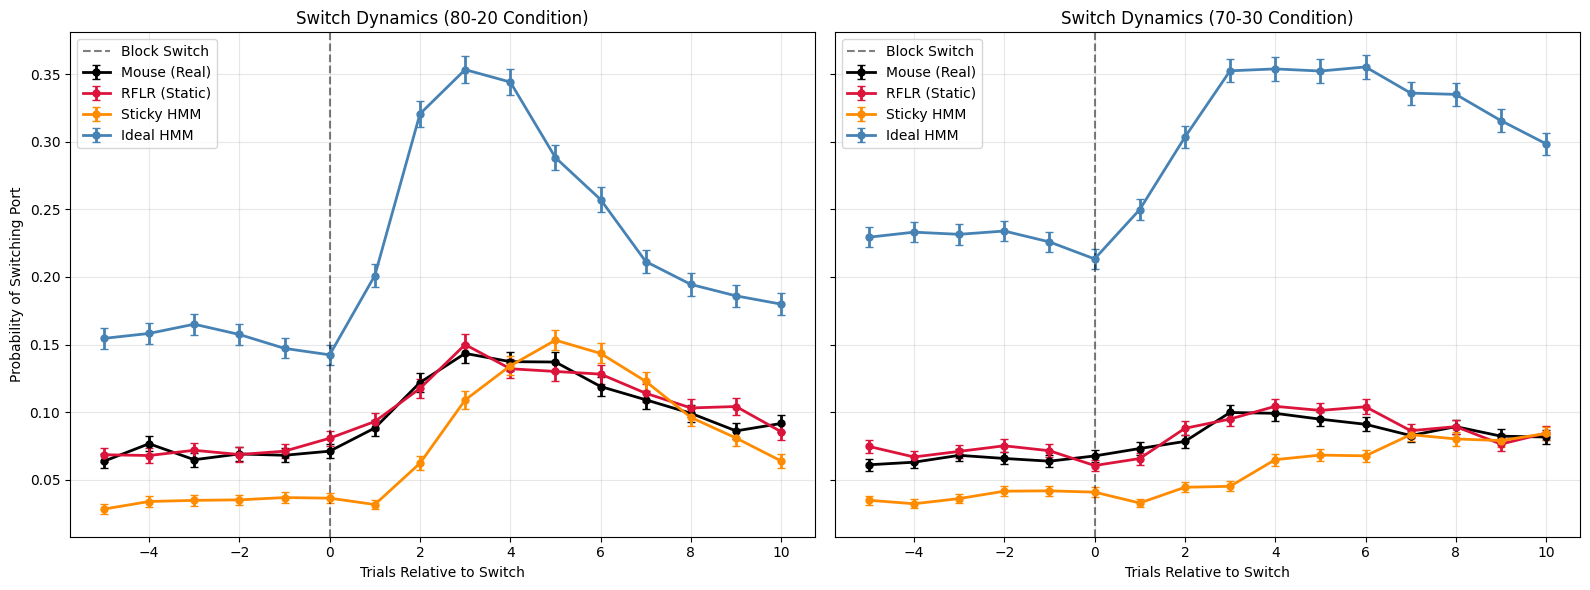

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

datasets = [
    ("80-20 Condition", sess_80, targ_80, sim_rflr_80, sim_sticky_80, sim_ideal_80),
    ("70-30 Condition", sess_70, targ_70, sim_rflr_70, sim_sticky_70, sim_ideal_70)
]

for ax, (title, sess, targ, sim_rflr, sim_sticky, sim_ideal) in zip(axes, datasets):
    models = [
        ("Mouse (Real)", sess, "black"), 
        ("RFLR (Static)", sim_rflr,"crimson"), 
        ("Sticky HMM", sim_sticky, "darkorange"), 
        ("Ideal HMM", sim_ideal, "steelblue")
    ]
    
    for name, data, col in models:
        x, y, err = get_switch_prob_around_transition(data, targ)
        ax.errorbar(x, y, yerr=err, label=name, color=col, capsize=3, lw=2, marker='o', markersize=5)
    
    ax.axvline(0, color='k', linestyle='--', alpha=0.5, label="Block Switch")
    ax.set_title(f"Switch Dynamics ({title})")
    ax.set_xlabel("Trials Relative to Switch")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    
    if title == "80-20 Condition":
        ax.set_ylabel("Probability of Switching Port")
        

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "Switch Dynamics.png"), dpi=300, bbox_inches='tight')
plt.show()

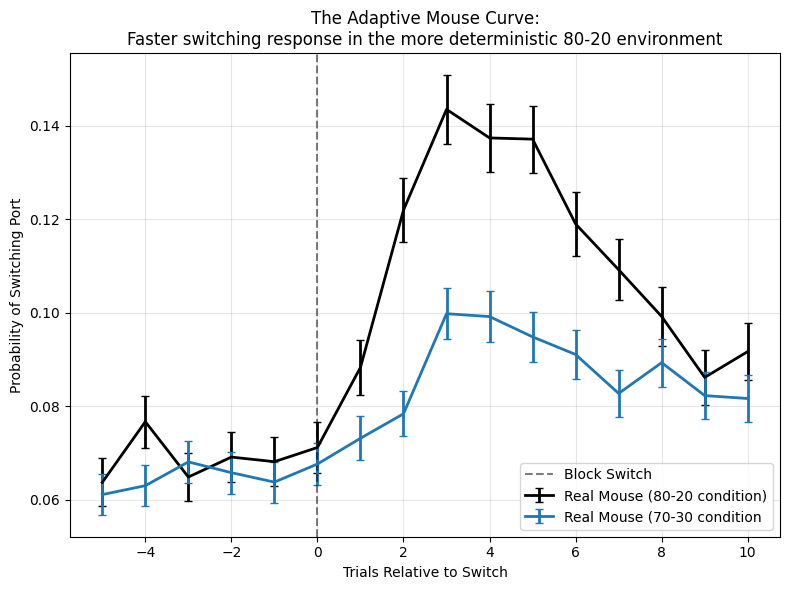

In [18]:
plt.figure(figsize=(8, 6))

# Get switch probabilities for both conditions
x_80, y_80, err_80 = get_switch_prob_around_transition(sess_80, targ_80)
x_70, y_70, err_70 = get_switch_prob_around_transition(sess_70, targ_70)

# Plot both curves
plt.errorbar(x_80, y_80, yerr=err_80, label="Real Mouse (80-20 condition)", color="black", capsize=3, lw=2)
plt.errorbar(x_70, y_70, yerr=err_70, label="Real Mouse (70-30 condition", color="tab:blue", capsize=3, lw=2)

plt.axvline(0, color='k', linestyle='--', alpha=0.5, label="Block Switch")
plt.xlabel("Trials Relative to Switch")
plt.ylabel("Probability of Switching Port")
plt.title("The Adaptive Mouse Curve:\nFaster switching response in the more deterministic 80-20 environment")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "The Adaptive Mouse Curve.png"), dpi=300, bbox_inches='tight')
plt.show()

In [19]:
def calc_metrics(sessions_list, label):
    data = []
    for c, r in sessions_list:
        n_switches = np.sum(np.abs(np.diff(c)))
        tot_reward = np.sum(r)
        data.append({
            "Model": label, 
            "Switches": n_switches, 
            "Reward": tot_reward
        })
    return pd.DataFrame(data)

In [20]:
df_metrics_80 = pd.concat([
    calc_metrics(sess_80, "Mouse (Real)"),
    calc_metrics(sim_rflr_80, "RFLR (Static)"),
    calc_metrics(sim_sticky_80, "Sticky HMM"),
    calc_metrics(sim_ideal_80, "Ideal HMM")
])
df_metrics_70 = pd.concat([
    calc_metrics(sess_70, "Mouse (Real)"),
    calc_metrics(sim_rflr_70, "RFLR (Static)"),
    calc_metrics(sim_sticky_70, "Sticky HMM"),
    calc_metrics(sim_ideal_70, "Ideal HMM")
])

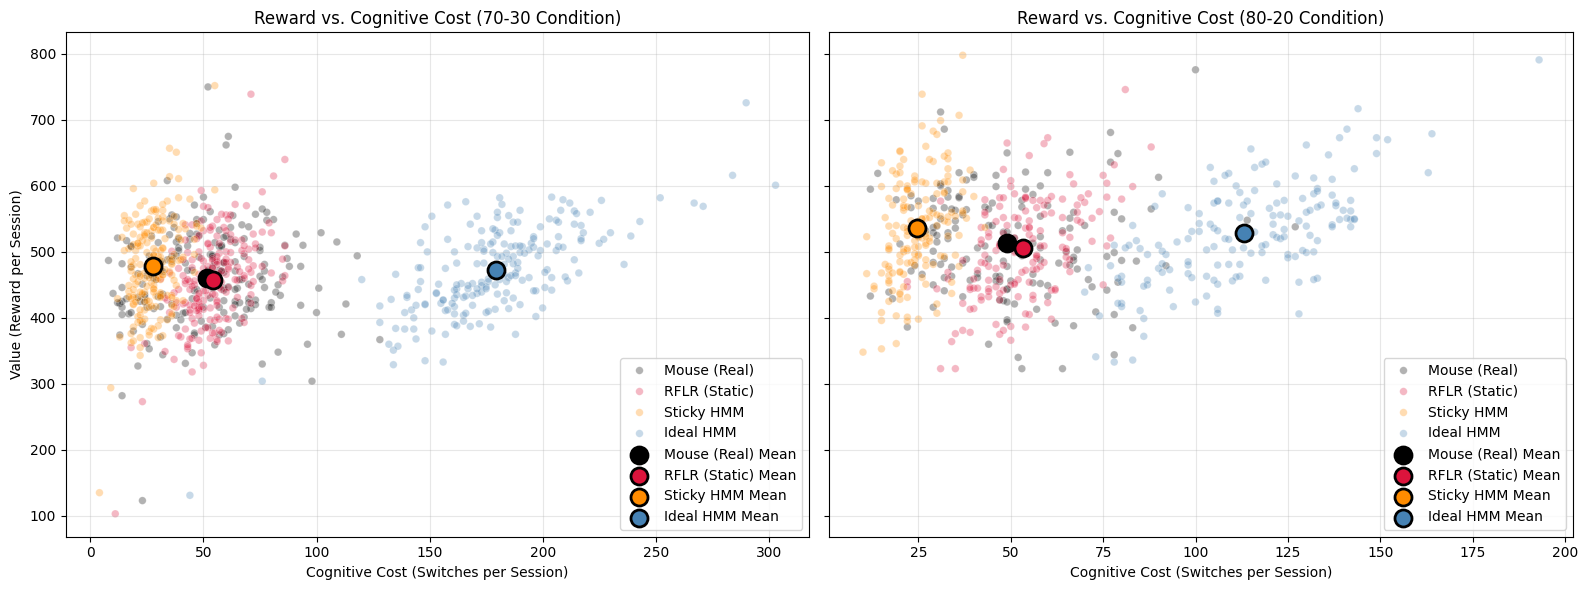

In [21]:
model_order = [
    "Mouse (Real)", 
    "RFLR (Static)", 
    "Sticky HMM", 
    "Ideal HMM"
]

model_colors = {
    "Mouse (Real)": "black",         # Solid baseline
    "RFLR (Static)": "crimson",      # Deep, distinct red
    "Sticky HMM": "darkorange",      # Vibrant orange
    "Ideal HMM": "steelblue"         # Cool blue
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

datasets = [(df_metrics_70, "70-30 Condition"), (df_metrics_80, "80-20 Condition")]

for ax, (df, title) in zip(axes, datasets):
    sns.scatterplot(data=df, x="Switches", y="Reward", hue="Model", 
                    palette=model_colors, hue_order=model_order, alpha=0.3, s=30, ax=ax)
    
    centroids = df.groupby("Model")[["Switches", "Reward"]].mean()
    for model_name in model_order: 
        row = centroids.loc[model_name]
        ax.scatter(
            row["Switches"], 
            row["Reward"], 
            s=150, 
            color=model_colors[model_name], 
            edgecolors='k', 
            linewidth=2, 
            zorder=5,
            label=f"{model_name} Mean"
        )
        
    ax.set_title(f"Reward vs. Cognitive Cost ({title})")
    ax.set_xlabel("Cognitive Cost (Switches per Session)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    

    if title == "70-30 Condition":
        ax.set_ylabel("Value (Reward per Session)")
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "Reward vs Cognitive Cost.png"), dpi=300, bbox_inches='tight')
plt.show()